In [26]:
# Import library utama
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [27]:
# Load Dataset
df = pd.read_excel('/content/data produksi padi (1).xlsx')

In [28]:
# Ganti nama kolom agar lebih mudah digunakan
df.columns = ["TAHUN", "SUBROUND", "PRODUKSI_PADI", "LUAS_PANEN"]

In [29]:
# Hapus baris kosong
df = df.dropna(subset=["TAHUN", "PRODUKSI_PADI"])

# Pastikan tipe data numerik
df["PRODUKSI_PADI"] = pd.to_numeric(df["PRODUKSI_PADI"], errors="coerce")
df = df.dropna(subset=["PRODUKSI_PADI"])

In [30]:
# Gabungkan tahun dan subround menjadi satu kolom waktu
# Misal Jan-Apr dianggap Q1, Mei-Ags = Q2, Sep-Des = Q3, dst.
mapping = {"Jan-Apr": "Q1", "Mei-Ags": "Q2", "Sep-Des": "Q3"}
df["PERIODE"] = df["TAHUN"].astype(str) + df["SUBROUND"].map(mapping)

# Gunakan format tanggal kuartal (pandas period)
df["DATE"] = pd.PeriodIndex(df["TAHUN"].astype(str) + df["SUBROUND"].map(mapping), freq='Q').to_timestamp()

# Urutkan data
df = df.sort_values("DATE").reset_index(drop=True)

# Set kolom waktu sebagai index
df.set_index("DATE", inplace=True)

=== DESKRIPSI STATISTIK DATA PRODUKSI PADI ===
count    1.400000e+01
mean     1.372952e+07
std      3.379977e+07
min      3.381250e+06
25%      4.473497e+06
50%      4.947090e+06
75%      5.067820e+06
max      1.311508e+08
Name: PRODUKSI_PADI, dtype: float64


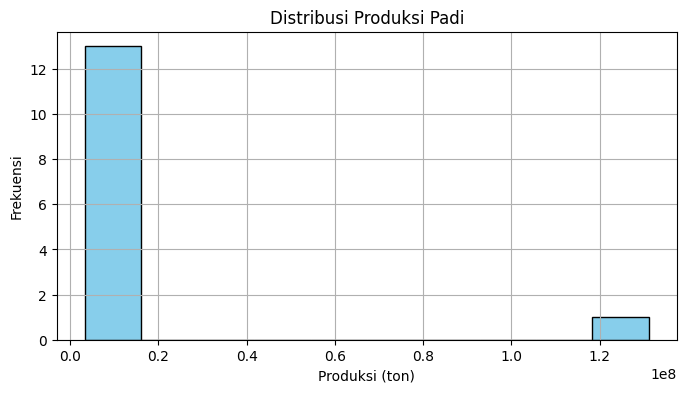

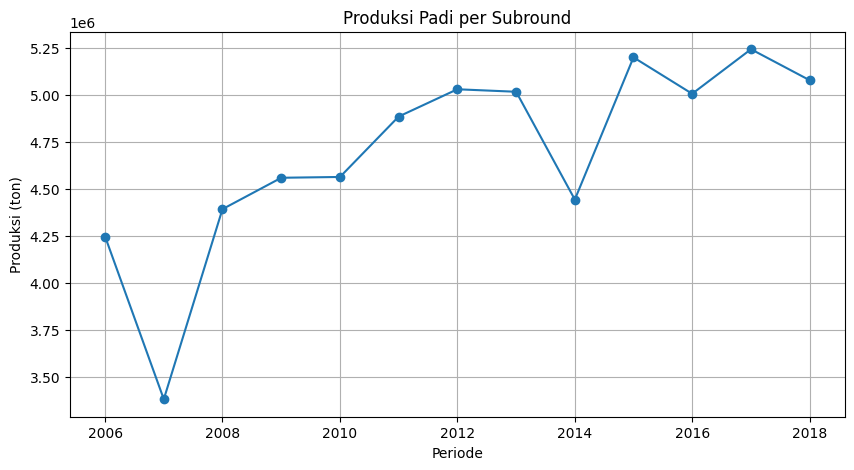

In [43]:
print("=== DESKRIPSI STATISTIK DATA PRODUKSI PADI ===")
print(df["PRODUKSI_PADI"].describe())

# Visualisasi distribusi data
plt.figure(figsize=(8,4))
plt.hist(df["PRODUKSI_PADI"], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribusi Produksi Padi")
plt.xlabel("Produksi (ton)")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()

# Plot time series
plt.figure(figsize=(10,5))
plt.plot(df.index, df["PRODUKSI_PADI"], marker='o')
plt.title("Produksi Padi per Subround")
plt.xlabel("Periode")
plt.ylabel("Produksi (ton)")
plt.grid(True)
plt.show()

In [44]:
from statsmodels.tsa.stattools import adfuller

print("=== UJI STASIONERITAS (Augmented Dickey-Fuller Test) ===")
result_adf = adfuller(df["PRODUKSI_PADI"].dropna())
print(f"ADF Statistic: {result_adf[0]}")
print(f"p-value: {result_adf[1]}")
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f"   {key}: {value}")

if result_adf[1] < 0.05:
    print("\n✅ Data stasioner (tolak H0)")
else:
    print("\n⚠️ Data belum stasioner (gagal tolak H0), perlu differencing")

=== UJI STASIONERITAS (Augmented Dickey-Fuller Test) ===
ADF Statistic: 7.751763580467995
p-value: 1.0
Critical Values:
   1%: -4.6651863281249994
   5%: -3.3671868750000002
   10%: -2.802960625

⚠️ Data belum stasioner (gagal tolak H0), perlu differencing


<Figure size 1000x800 with 0 Axes>

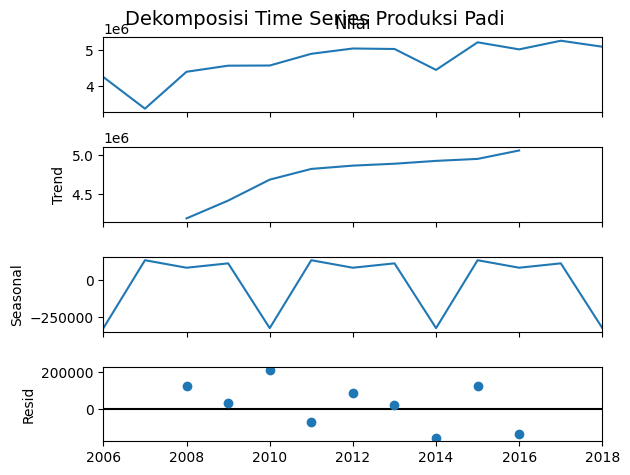


=== Contoh Nilai Komponen Dekomposisi ===
                   Trend       Seasonal       Residual
DATE                                                  
2006-01-01           NaN -325687.527217            NaN
2007-01-01           NaN  132505.844536            NaN
2008-01-01  4.185301e+06   81844.291595  126333.627756
2009-01-01  4.413142e+06  111337.391085   36029.322617
2010-01-01  4.681065e+06 -325687.527217  209388.199610
2011-01-01  4.818091e+06  132505.844536  -64215.503834
2012-01-01  4.860301e+06   81844.291595   89584.246756
2013-01-01  4.884671e+06  111337.391085   22455.511022
2014-01-01  4.921084e+06 -325687.527217 -150903.365970
2015-01-01  4.946409e+06  132505.844536  122700.337474


In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Dekomposisi dengan model aditif
# Use df_original_temp which has the quarterly datetime index and 'Nilai' column
# Assuming df_original_temp is available from the execution of cell oTUsJEEvD0JM
decompose_result = seasonal_decompose(df_original_temp["Nilai"], model='additive', period=4)

# Plot hasil dekomposisi
plt.figure(figsize=(10,8))
decompose_result.plot()
plt.suptitle("Dekomposisi Time Series Produksi Padi", fontsize=14)
plt.show()

# Komponen hasil dekomposisi
trend_component = decompose_result.trend
seasonal_component = decompose_result.seasonal
residual_component = decompose_result.resid

# Tampilkan beberapa nilai komponen
print("\n=== Contoh Nilai Komponen Dekomposisi ===")
print(pd.DataFrame({
    "Trend": trend_component,
    "Seasonal": seasonal_component,
    "Residual": residual_component
}).head(10))

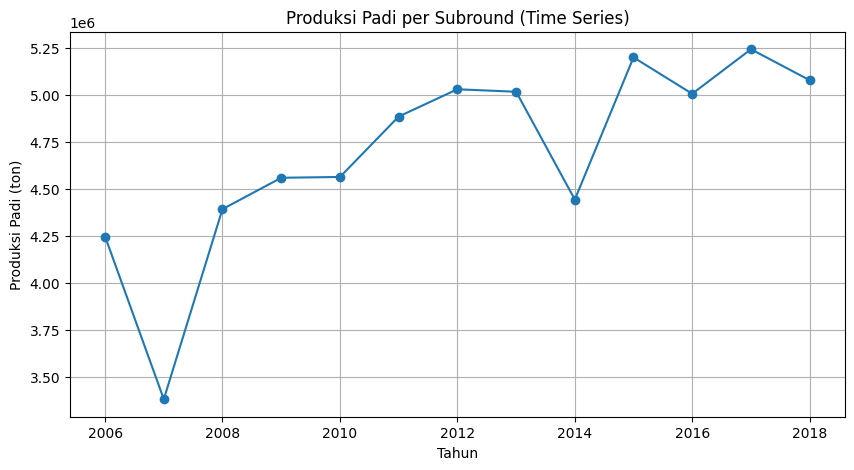

In [31]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df["PRODUKSI_PADI"], marker='o')
plt.title("Produksi Padi per Subround (Time Series)")
plt.xlabel("Tahun")
plt.ylabel("Produksi Padi (ton)")
plt.grid(True)
plt.show()

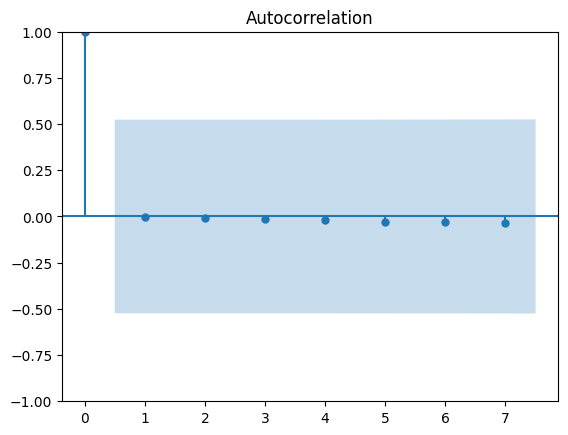

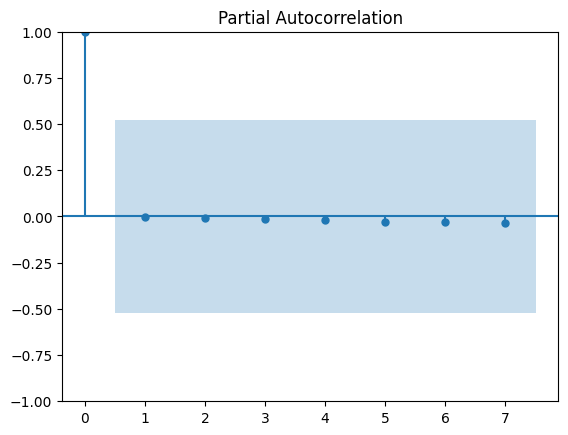

In [32]:
plot_acf(df["PRODUKSI_PADI"])
plot_pacf(df["PRODUKSI_PADI"])
plt.show()

In [33]:
# Misal hasil dari analisis menunjukkan p=1, d=1, q=1 dan P=1, D=1, Q=1, s=4
model = SARIMAX(df["PRODUKSI_PADI"], order=(1,1,1), seasonal_order=(1,1,1,4))
result = model.fit(disp=False)

print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     PRODUKSI_PADI   No. Observations:                   14
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -170.942
Date:                           Fri, 07 Nov 2025   AIC                            351.884
Time:                                   06:45:02   BIC                            352.870
Sample:                                        0   HQIC                           349.756
                                            - 14                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9959     57.597      0.017      0.986    -111.893     113.885
ma.L1          0.0109     63.773      0.000

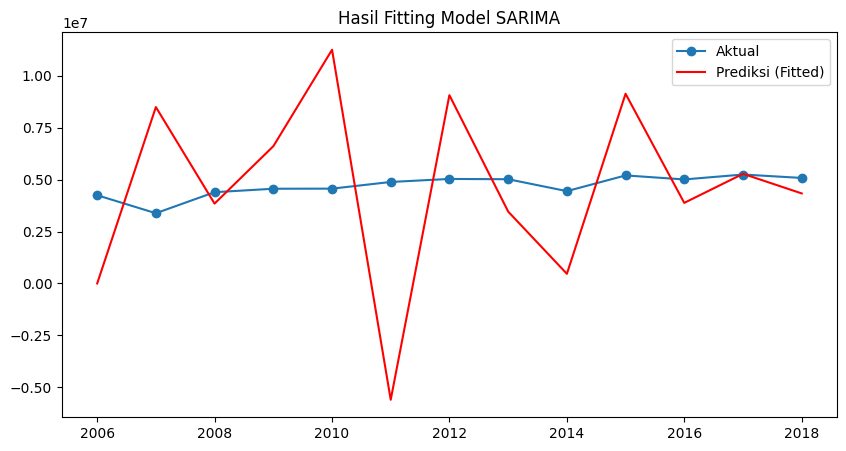

In [34]:
df["Predicted"] = result.fittedvalues

plt.figure(figsize=(10,5))
plt.plot(df.index, df["PRODUKSI_PADI"], label="Aktual", marker='o')
plt.plot(df.index, df["Predicted"], label="Prediksi (Fitted)", color='red')
plt.legend()
plt.title("Hasil Fitting Model SARIMA")
plt.show()

Seasonal Naive Forecast (8 Subround ke Depan):
                Forecast
2018-03-31  5.079850e+06
2018-06-30           NaN
2018-09-30           NaN
2018-12-31           NaN
2019-03-31  5.079850e+06
2019-06-30           NaN
2019-09-30           NaN
2019-12-31           NaN


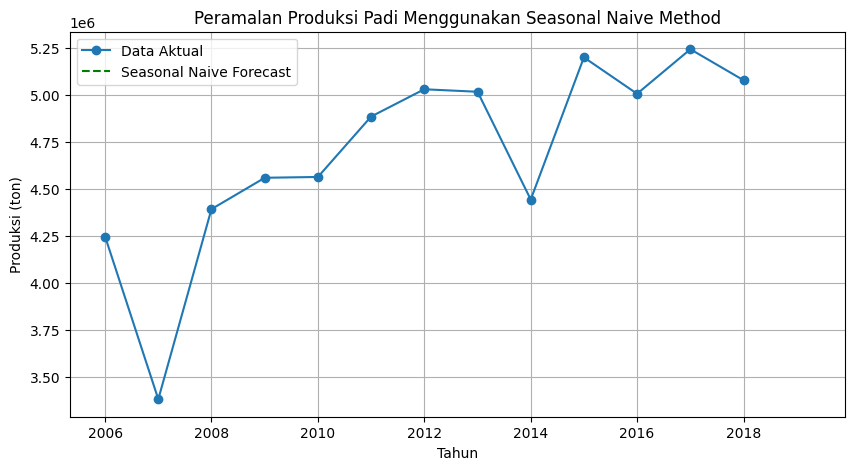

In [42]:
# Generate Seasonal Naive forecast using df_original_temp

# Ensure df_original_temp is available from previous cells or re-create it if necessary
# Assuming df_original_temp is available from the execution of cell oTUsJEEvD0JM

# Determine the last observed value for each quarter
last_q1_value = df_original_temp[df_original_temp.index.quarter == 1]['Nilai'].iloc[-1]
last_q2_value = df_original_temp[df_original_temp.index.quarter == 2]['Nilai'].iloc[-1] if 2 in df_original_temp.index.quarter else None
last_q3_value = df_original_temp[df_original_temp.index.quarter == 3]['Nilai'].iloc[-1] if 3 in df_original_temp.index.quarter else None
last_q4_value = df_original_temp[df_original_temp.index.quarter == 4]['Nilai'].iloc[-1] if 4 in df_original_temp.index.quarter else None

last_seasonal_values = {
    1: last_q1_value,
    2: last_q2_value,
    3: last_q3_value,
    4: last_q4_value
}

forecast_steps = 8 # Forecast for 8 quarters (2 years)
last_date = df_original_temp.index[-1]

# Generate the forecast index starting from the next quarter after the last observed date
forecast_index_naive = pd.date_range(start=last_date + pd.offsets.QuarterBegin(1), periods=forecast_steps, freq='Q')

# Generate the forecast values based on the last observed seasonal values
forecast_values_naive = [last_seasonal_values.get(date.quarter) for date in forecast_index_naive]

forecast_df_naive = pd.DataFrame({
    "Forecast": forecast_values_naive
}, index=forecast_index_naive)

print("Seasonal Naive Forecast (8 Subround ke Depan):")
print(forecast_df_naive)

# Optional: Plot the Seasonal Naive forecast with actual data
plt.figure(figsize=(10,5))
plt.plot(df_original_temp.index, df_original_temp["Nilai"], label="Data Aktual", marker='o')
plt.plot(forecast_df_naive.index, forecast_df_naive["Forecast"], label="Seasonal Naive Forecast", color='green', linestyle='--')
plt.legend()
plt.title("Peramalan Produksi Padi Menggunakan Seasonal Naive Method")
plt.xlabel("Tahun")
plt.ylabel("Produksi (ton)")
plt.grid(True)
plt.show()

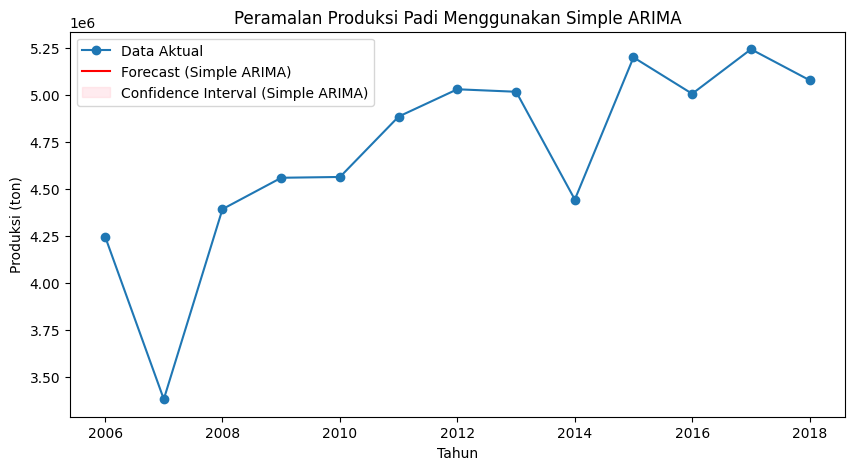

Hasil Peramalan Produksi Padi dengan Simple ARIMA (8 Subround ke Depan):
            Forecast  Lower CI  Upper CI
2018-06-30       NaN       NaN       NaN
2018-09-30       NaN       NaN       NaN
2018-12-31       NaN       NaN       NaN
2019-03-31       NaN       NaN       NaN
2019-06-30       NaN       NaN       NaN
2019-09-30       NaN       NaN       NaN
2019-12-31       NaN       NaN       NaN
2020-03-31       NaN       NaN       NaN


In [41]:
# Ensure df_original_temp is available from previous cells or re-create it if necessary
# Assuming df_original_temp is available from the execution of cell oTUsJEEvD0JM
# and result_simple is available from cell bae85375

last_date = df_original_temp.index[-1]

forecast_steps = 8  # misal 8 subround ke depan (2 tahun)
# Use result_simple for forecasting
forecast_simple = result_simple.get_forecast(steps=forecast_steps)

# Generate the forecast index starting from the last actual date with quarterly frequency
forecast_index_simple = pd.date_range(last_date, periods=forecast_steps + 1, freq='Q')[1:]

forecast_df_simple = pd.DataFrame({
    "Forecast": forecast_simple.predicted_mean,
    "Lower CI": forecast_simple.conf_int().iloc[:, 0],
    "Upper CI": forecast_simple.conf_int().iloc[:, 1]
}, index=forecast_index_simple)

plt.figure(figsize=(10,5))
# Plot the original data using the df_original_temp with quarterly datetime index
plt.plot(df_original_temp.index, df_original_temp["Nilai"], label="Data Aktual", marker='o') # Use df_original_temp.index for historical
# Plot the forecast from the simpler model
plt.plot(forecast_df_simple.index, forecast_df_simple["Forecast"], label="Forecast (Simple ARIMA)", color='red')
plt.fill_between(forecast_df_simple.index, forecast_df_simple["Lower CI"], forecast_df_simple["Upper CI"],
                 color='pink', alpha=0.3, label="Confidence Interval (Simple ARIMA)")
plt.legend()
plt.title("Peramalan Produksi Padi Menggunakan Simple ARIMA")
plt.xlabel("Tahun")
plt.ylabel("Produksi (ton)")
plt.show()

print("Hasil Peramalan Produksi Padi dengan Simple ARIMA (8 Subround ke Depan):")
print(forecast_df_simple)

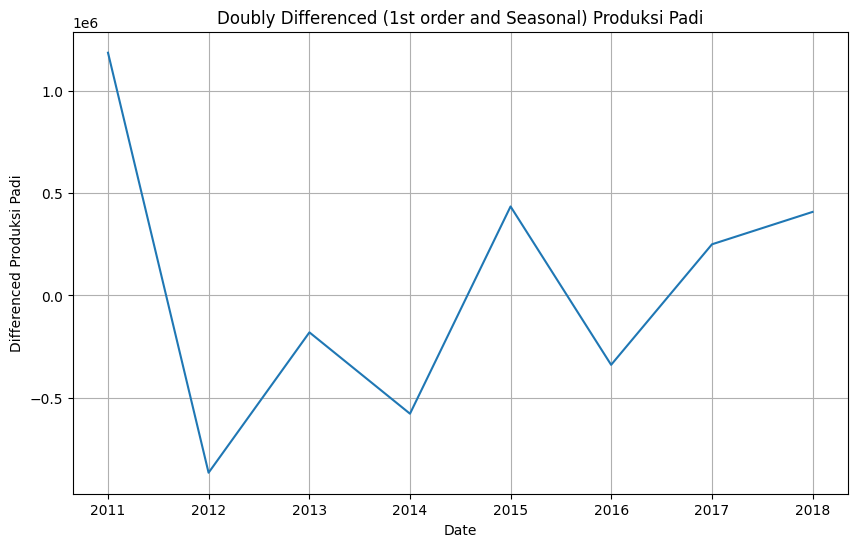

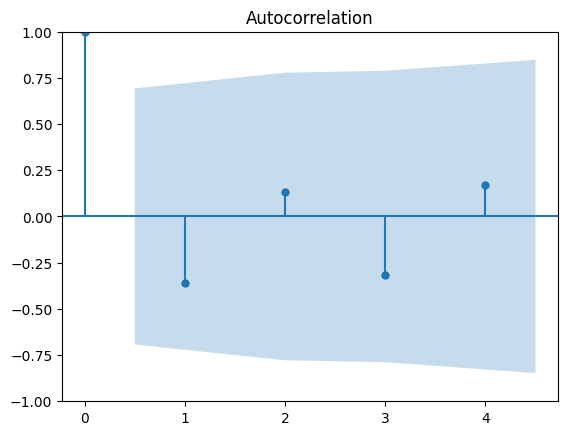

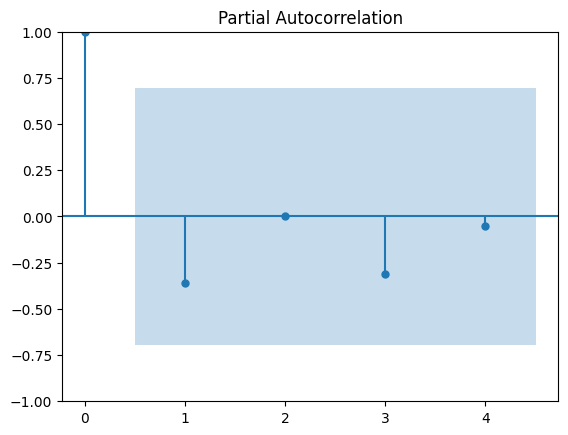

In [39]:
# Use the df_original_temp which has the quarterly data and datetime index
# Ensure df_original_temp is available from previous cells or re-create it if necessary
# Assuming df_original_temp is available from the execution of cell oTUsJEEvD0JM

# Apply first-order differencing
df_diff = df_original_temp['Nilai'].diff(periods=1)

# Apply seasonal differencing (s=4 for quarterly)
df_diff_seasonal = df_diff.diff(periods=4)

# Drop NaN values created by differencing
df_diff_seasonal = df_diff_seasonal.dropna()

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(df_diff_seasonal)
plt.title('Doubly Differenced (1st order and Seasonal) Produksi Padi')
plt.xlabel('Date')
plt.ylabel('Differenced Produksi Padi')
plt.grid(True)
plt.show()

# Optionally, plot ACF and PACF of the differenced series to further check stationarity
plot_acf(df_diff_seasonal)
plot_pacf(df_diff_seasonal)
plt.show()

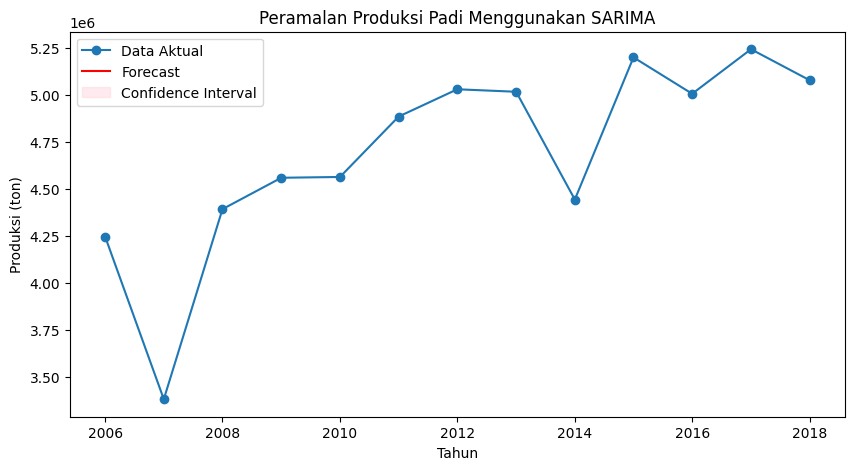

In [37]:
# Make sure to have the original df with DATE column available or recalculate it
# Assuming df_original is the DataFrame before setting the yearly index

# If df_original is not available, recreate the date column from the current df
# Let's load the original data again to ensure we have the necessary columns and quarterly dates
df_original_temp = pd.read_excel('/content/data produksi padi (1).xlsx', skiprows=2, header=0)
df_original_temp = df_original_temp.rename(columns={'Unnamed: 0':'TAHUN', 'Unnamed: 1':'SUBROUND', 'Unnamed: 2':'Nilai'})
df_original_temp = df_original_temp[df_original_temp['TAHUN'].astype(str).str.match(r'^\d{4}$')]
df_original_temp['DATE'] = pd.PeriodIndex(df_original_temp["TAHUN"].astype(str) + df_original_temp["SUBROUND"].map(mapping), freq='Q').to_timestamp()

# Convert 'Nilai' to numeric, coercing errors to NaN and drop NaNs
df_original_temp['Nilai'] = pd.to_numeric(df_original_temp['Nilai'], errors='coerce')
df_original_temp.dropna(subset=['Nilai'], inplace=True)

# Set the DATE column as index for plotting historical data
df_original_temp.set_index('DATE', inplace=True)


last_date = df_original_temp.index[-1]


forecast_steps = 8  # misal 8 subround ke depan (2 tahun)
forecast = result.get_forecast(steps=forecast_steps)
# Generate the forecast index starting from the last actual date with quarterly frequency
forecast_index = pd.date_range(last_date, periods=forecast_steps + 1, freq='Q')[1:]

forecast_df = pd.DataFrame({
    "Forecast": forecast.predicted_mean,
    "Lower CI": forecast.conf_int().iloc[:, 0],
    "Upper CI": forecast.conf_int().iloc[:, 1]
}, index=forecast_index)

plt.figure(figsize=(10,5))
# Plot the original data using the df_original_temp with quarterly datetime index
plt.plot(df_original_temp.index, df_original_temp["Nilai"], label="Data Aktual", marker='o') # Use df_original_temp.index for historical
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast", color='red') # Use quarterly forecast_index for forecast
plt.fill_between(forecast_df.index, forecast_df["Lower CI"], forecast_df["Upper CI"],
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.legend()
plt.title("Peramalan Produksi Padi Menggunakan SARIMA")
plt.xlabel("Tahun")
plt.ylabel("Produksi (ton)")
plt.show()

In [38]:
print("Hasil Peramalan Produksi Padi (8 Subround ke Depan):")
print(forecast_df)

Hasil Peramalan Produksi Padi (8 Subround ke Depan):
            Forecast  Lower CI  Upper CI
2018-06-30       NaN       NaN       NaN
2018-09-30       NaN       NaN       NaN
2018-12-31       NaN       NaN       NaN
2019-03-31       NaN       NaN       NaN
2019-06-30       NaN       NaN       NaN
2019-09-30       NaN       NaN       NaN
2019-12-31       NaN       NaN       NaN
2020-03-31       NaN       NaN       NaN


Hasil peramalan:
13    5.140869e+06
14    5.108912e+06
15    5.125649e+06
16    5.116883e+06
17    5.121474e+06
Name: predicted_mean, dtype: float64


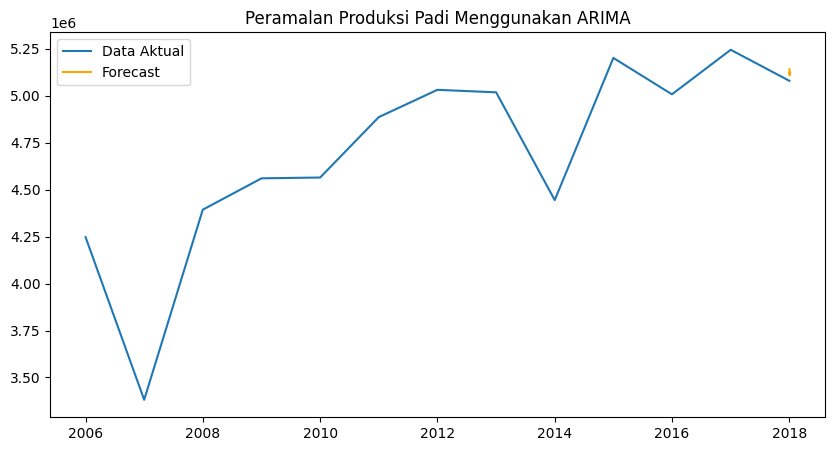

In [51]:
# Ensure df_original_temp is available from previous cells or re-create it if necessary
# Assuming df_original_temp is available from the execution of cell oTUsJEEvD0JM
# Assuming model_fit is available from the execution of cell _8quwoCqPKva


forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)
print("Hasil peramalan:")
print(forecast)

# 10. Visualisasi hasil peramalan
plt.figure(figsize=(10,5))
# Plot actual data using df_original_temp
plt.plot(df_original_temp['Nilai'], label='Data Aktual')

# Generate forecast index starting from the date after the last actual date
last_date_actual = df_original_temp.index[-1]
forecast_index = pd.date_range(start=last_date_actual, periods=forecast_steps + 1, freq=df_original_temp.index.freq)[1:]


plt.plot(forecast_index, forecast, label='Forecast', color='orange')
plt.title('Peramalan Produksi Padi Menggunakan ARIMA')
plt.legend()
plt.show()


📈 Hasil Peramalan 5 Subround ke Depan:
13    5.140869e+06
14    5.108912e+06
15    5.125649e+06
16    5.116883e+06
17    5.121474e+06
Name: predicted_mean, dtype: float64


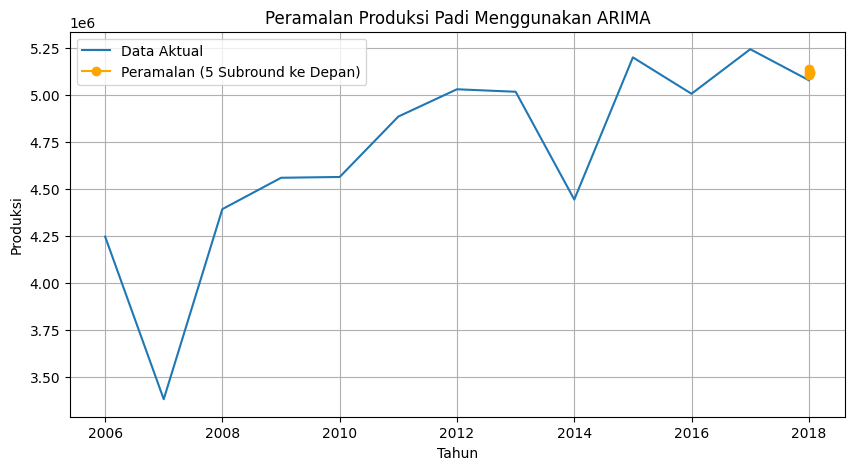

In [55]:
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)

# Use the last date from df_original_temp for generating the forecast index
last_date_actual = df_original_temp.index[-1]
future_index = pd.date_range(start=last_date_actual, periods=forecast_steps + 1, freq=df_original_temp.index.freq)[1:]


print("\n📈 Hasil Peramalan 5 Subround ke Depan:")
print(forecast) # forecast is a Series, no need for forecast_series

# 10. Visualisasi Hasil Peramalan
plt.figure(figsize=(10,5))
# Plot actual data using df_original_temp with quarterly datetime index
plt.plot(df_original_temp['Nilai'], label='Data Aktual')
# Plot the forecast using the correctly generated quarterly index
plt.plot(future_index, forecast, label='Peramalan (5 Subround ke Depan)', color='orange', marker='o')
plt.title('Peramalan Produksi Padi Menggunakan ARIMA')
plt.xlabel('Tahun')
plt.ylabel('Produksi')
plt.legend()
plt.grid(True)
plt.show()